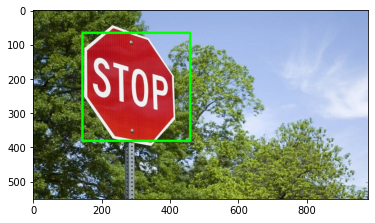

In [10]:
import cv2
from matplotlib import pyplot as plt

# Opening image
#img = cv2.imread("Images\IMG_20211021_133817.jpg")
img = cv2.imread("image.jpg")
# OpenCV opens images as BRG
# but we want it as RGB We'll
# also need a grayscale version
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Use minSize because for not
# bothering with extra-small
# dots that would look like STOP signs
stop_data = cv2.CascadeClassifier('stop_data.xml')

found = stop_data.detectMultiScale(img_gray, minSize =(20, 20))

# Don't do anything if there's
# no sign
amount_found = len(found)

if amount_found != 0:
	
	# There may be more than one
	# sign in the image
	for (x, y, width, height) in found:
		
		# We draw a green rectangle around
		# every recognized sign
		cv2.rectangle(img_rgb, (x, y),
					(x + height, y + width),
					(0, 255, 0), 5)
		
# Creates the environment of
# the picture and shows it
plt.subplot(1, 1, 1)
plt.imshow(img_rgb)
plt.show()

